In [101]:
import glob
import numpy as np
import pandas as pd
import datetime as dt
from scipy.interpolate import interp1d
from sklearn.neural_network import multilayer_perceptron
from sklearn.decomposition import PCA
from matplotlib import dates as mdates, pyplot as plt
%matplotlib inline

DAY_SECONDS = 60 * 60 * 24
SERIES_WIDTH = 2 * 60
POINTS_IN_DAY = np.round(DAY_SECONDS / SERIES_WIDTH).astype(int)
COLUMNS= {'active': 'General Activity', 'vc_0': 'Web Status', 'vc_8': 'FB App Status', 'vc_74': 'Messenger Status', 'vc_10':'Other Status', 'type': 'Activity Type'}
features = 6

In [102]:
# read data
names = glob.glob('./generated_graphs/csv/*.csv')
data = [pd.read_csv(f).rename(columns=COLUMNS) for f in names]
print("Loaded data gathered from {0} people".format(len(data)))
datasets = len(data)

Loaded data gathered from 434 people


In [103]:
start = np.min(pd.concat(data)['time'].dropna(0))

for i in range(len(data)):
    data[i]['time'] -= start
    
end = np.max(pd.concat(data)['time'])
print('First registered data point at {0}\nGathered data over {1}'.format(dt.datetime.utcfromtimestamp(start), dt.datetime.utcfromtimestamp(end).strftime('%d days, %Hh:%Mm')))

First registered data point at 2018-12-31 12:57:32
Gathered data over 09 days, 23h:17m


In [104]:
# nearest neighbour interpolation to get set width timeseries
series = []
timeseries = np.arange(0, end, SERIES_WIDTH)

for i in range(len(data)):
    interpolate = interp1d(data[i]['time'], data[i].iloc[:, 1:], axis=0, kind='nearest', bounds_error=False, fill_value=np.zeros(features))
    df = pd.DataFrame(columns=data[0].columns)
    df['time'] = timeseries
    df.iloc[:, 1:] = interpolate(timeseries)
    series.append(df)
    
series[0].head()

,time,General Activity,Web Status,FB App Status,Other Status,Messenger Status,Activity Type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120.0,0.0,0.0,0.0,0.0,0.0,0.0
2,240.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360.0,0.0,0.0,0.0,0.0,0.0,0.0
4,480.0,0.0,0.0,0.0,0.0,0.0,0.0


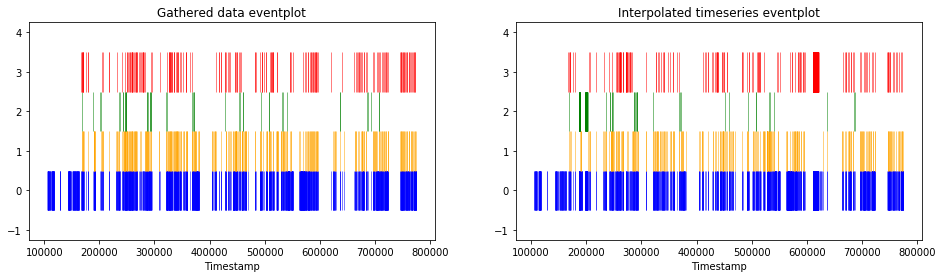

In [105]:
dataset = data[0]
interesting = ['General Activity', 'Messenger Status', 'FB App Status', 'Web Status']
events = [dataset[dataset[key] == 1]['time'] for key in interesting]

dataset = series[0]
events_series = [dataset[dataset[key] == 1]['time'] for key in interesting]

fig = plt.figure(figsize=[16, 4])

ax = fig.add_subplot(1, 2, 1)
for (event, place, color) in zip(events, range(4), ['blue', 'orange', 'green', 'red']):
    ax.eventplot(event, color=color, lineoffsets=place, linewidths = 0.5)
ax.set_title('Gathered data eventplot')
ax.set_xlabel('Timestamp')

ax = fig.add_subplot(1, 2, 2)
for (event, place, color) in zip(events_series, range(4), ['blue', 'orange', 'green', 'red']):
    ax.eventplot(event, color=color, lineoffsets=place, linewidths = 0.5)
ax.set_title('Interpolated timeseries eventplot')
ax.set_xlabel('Timestamp')

plt.show()

In [106]:
days = np.floor(end / DAY_SECONDS).astype(int)
y_train = np.empty((datasets, days, POINTS_IN_DAY, features))

#model = multilayer_perceptron.MLPRegressor(activation='relu', batch_size=1000, hidden_layer_sizes=[1000], verbose=2)

for i in range(datasets):
    for j in range(days):
        y_train[i, j] = series[i].iloc[j * POINTS_IN_DAY : (j + 1) * POINTS_IN_DAY, 1:]

#model.fit([[s, i] for i in range(days) for s in range(datasets)], y_train.reshape(datasets * days, features * POINTS_IN_DAY))

In [113]:
days = np.floor(end / DAY_SECONDS).astype(int)

average = pd.DataFrame(columns=data[0].columns)
average['time'] = timeseries[timeseries < DAY_SECONDS]

av = np.zeros((POINTS_IN_DAY, features))
for i in range(datasets):
    for j in range(days):
        av += y_train[i, j]
        
av /= (datasets * days)

average.iloc[:, 1:] = av
print('{0} full days worth of data collected'.format(days))

8 full days worth of data collected


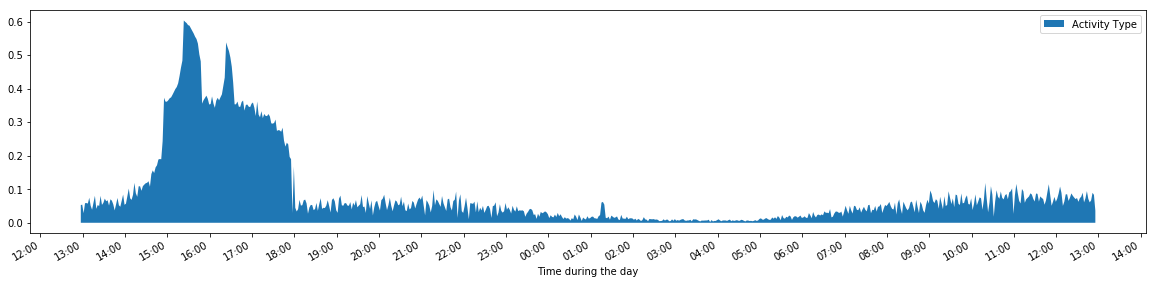

In [114]:
def plot_feature(average, feature):
    plt.figure(figsize=(20,10))

    # activity
    ax1 = plt.subplot(211)
    xs = [dt.datetime.utcfromtimestamp(t + start) for t in average['time']]
    ax1.stackplot(xs, average[feature].transpose())

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gcf().autofmt_xdate()
    plt.legend([feature])
    plt.xlabel('Time during the day')
    
plot_feature(average, 'Activity Type')

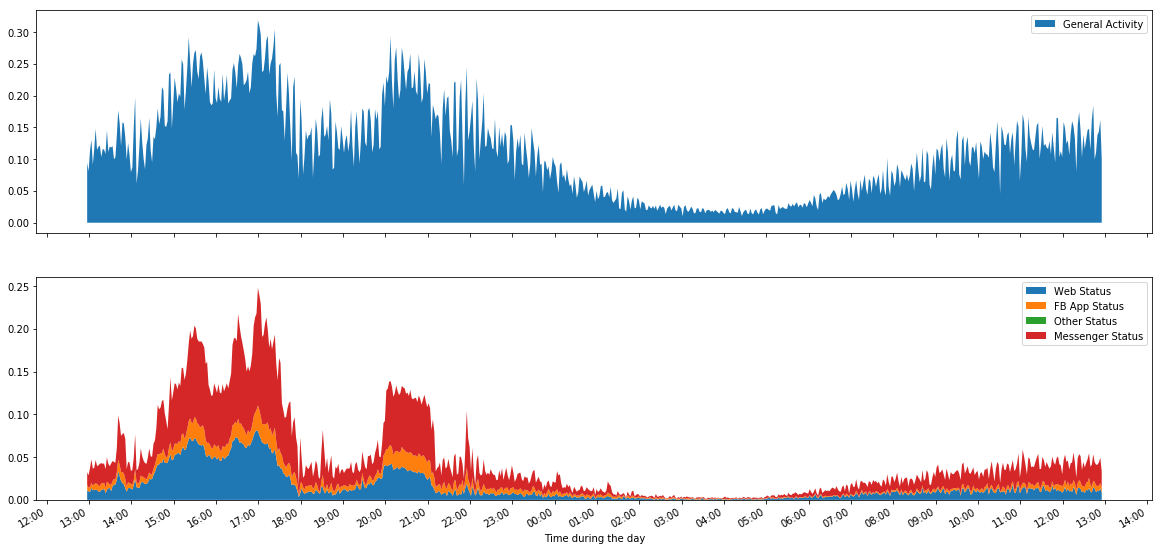

In [115]:
def plot_habits(average):
    plt.figure(figsize=(20,10))

    # activity
    ax1 = plt.subplot(211)
    xs = [dt.datetime.utcfromtimestamp(t + start) for t in average['time']]
    ax1.stackplot(xs, average['General Activity'].transpose())

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gcf().autofmt_xdate()
    plt.legend([average.columns[1]])

    # divided into classes
    ax2 = plt.subplot(212, sharex=ax1)
    xs = [dt.datetime.utcfromtimestamp(t + start) for t in average['time']]
    ax2.stackplot(xs, average.iloc[:, 2:-1].transpose())

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gcf().autofmt_xdate()

    plt.legend(average.columns[2:-1])
    plt.xlabel('Time during the day')
    plt.show()
    
plot_habits(average)

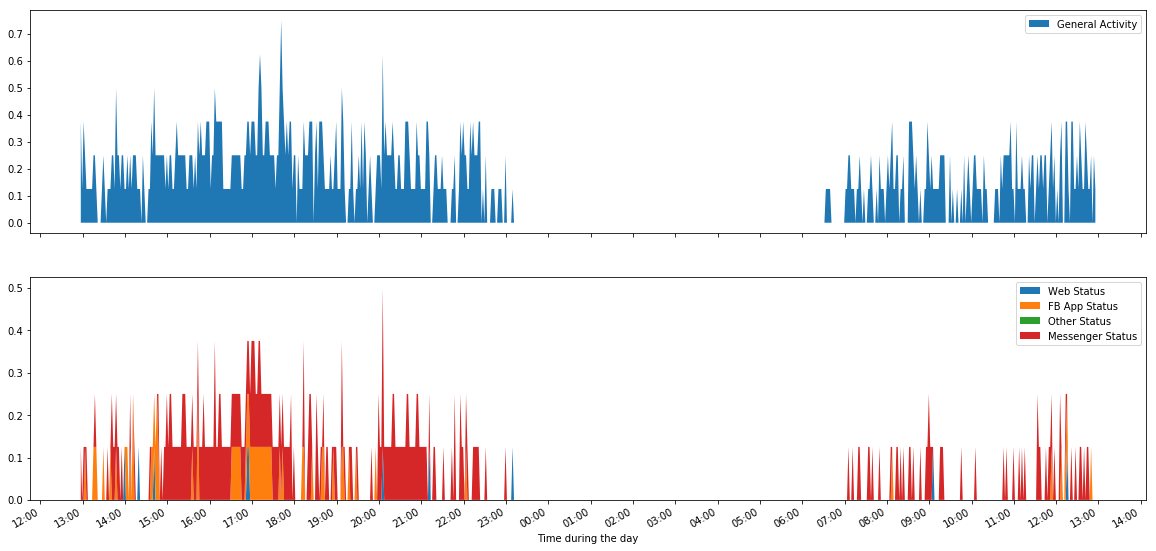

In [116]:
def find_name(name):
    for i in range(len(names)):
        if name in names[i]:
            return i
    raise Exception('Student {0} not found!'.format(name))

def student_average(name):
    i = find_name(name)

    average = pd.DataFrame(columns=data[0].columns)
    average['time'] = timeseries[timeseries < DAY_SECONDS]

    av = 0 * y_train[0, 0]
    for j in range(days):
        av += y_train[i, j]

    av /= days

    average.iloc[:, 1:] = av
    return average

plot_habits(student_average('***REMOVED***'))

In [117]:
n_components = 2

students = np.mean(y_train, axis=1).reshape((datasets, POINTS_IN_DAY * features))
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(students)

reduced = pca.transform(students).reshape((datasets, n_components))

Text(0.5,1,'2D PCA')

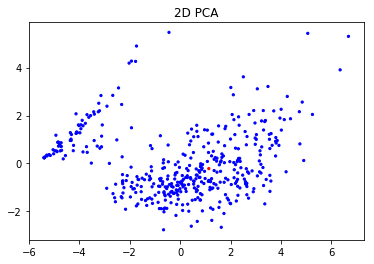

In [118]:
plt.scatter(reduced[:, 0], reduced[:, 1], s=5, c=['r' if i == find_name('***REMOVED***') else 'b' for i in range(len(reduced))])
plt.title('{0}D PCA'.format(n_components))